In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from imblearn.pipeline import Pipeline as imbpipeline

In [3]:
df = pd.read_pickle('dropped_na_data.pickle')

# Data Cleaning

In [4]:
unknown= df.loc[(df['population']==0)&(df['construction_year']==0)&(df['amount_tsh']==0)&(df['gps_height']==0)]

In [5]:
def missing(row): 
    if (row['population']==0)&(row['construction_year']==0)&(row['amount_tsh']==0)&(row['gps_height']==0):
        return 1
    else:
        return 0 


In [6]:
df['missing']= df.apply(lambda row : missing(row), axis=1)

In [7]:
X = df.drop('status_group', axis=1)
X.shape

(59400, 19)

In [8]:
y= df['status_group']

In [9]:
le = LabelEncoder()

In [10]:
y=le.fit_transform(df['status_group'])

#0 = functional, 1= need repair, 2= non functional 

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=42, stratify=y)

In [12]:
cat_columns= [col for col in X.columns if X[col].dtype in ['object']]

In [13]:
num_columns = [col for col in X.columns if X[col].dtypes in ['float64', 'int64']]

num_columns

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'district_code',
 'population',
 'construction_year',
 'missing']

In [14]:
zero_pipe=Pipeline(steps= [
    ('ss', StandardScaler())
])

In [15]:
cat_pipe=Pipeline(steps= [
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [16]:
coltran= ColumnTransformer(transformers=[
    ('zero', zero_pipe , num_columns), 
    ('cat_pipe', cat_pipe, cat_columns)
],remainder= 'passthrough')


In [17]:
coltran.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('zero',
                                 Pipeline(steps=[('ss', StandardScaler())]),
                                 ['amount_tsh', 'gps_height', 'longitude',
                                  'latitude', 'district_code', 'population',
                                  'construction_year', 'missing']),
                                ('cat_pipe',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['basin', 'region', 'lga', 'ward',
                                  'extraction_type', 'management', 'payment',
                                  'water_quality', 'quantity', 'source_type',
                                  'waterpoint_type'])])

In [18]:
X_cleaned_train= coltran.transform(X_train)

In [19]:
X_cleaned_test = coltran.transform(X_test)

In [20]:
#the order of the column name has to match the order of the column transformer 
cat_columns = coltran.named_transformers_['cat_pipe']['ohe'].get_feature_names(cat_columns).tolist()
all_columns = num_columns + cat_columns 

cleaned_df_train = pd.DataFrame(X_cleaned_train, columns=all_columns)
cleaned_df_test = pd.DataFrame(X_cleaned_test, columns=all_columns)

In [21]:
cleaned_df_train[num_columns].describe()

,amount_tsh,gps_height,longitude,latitude,district_code,population,construction_year,missing
count,4.752000e+04,4.752000e+04,4.752000e+04,4.752000e+04,4.752000e+04,4.752000e+04,4.752000e+04,4.752000e+04
mean,8.272823e-16,-1.059440e-15,-3.949796e-16,1.809836e-17,-7.144505e-16,9.017466e-17,1.512819e-15,-1.572456e-15
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,-1.006895e-01,-1.057099e+00,-5.201849e+00,-2.020702e+00,-5.837933e-01,-3.882845e-01,-1.369972e+00,-7.020572e-01
25%,-1.006895e-01,-9.661892e-01,-1.511435e-01,-9.595306e-01,-3.759175e-01,-3.882845e-01,-1.369972e+00,-7.020572e-01
50%,-1.006895e-01,-4.286700e-01,1.264211e-01,2.327237e-01,-2.719796e-01,-3.342978e-01,7.184756e-01,-7.020572e-01
75%,-9.287021e-02,9.385769e-01,4.713299e-01,8.087446e-01,-6.410379e-02,7.600142e-02,7.374041e-01,1.424385e+00
max,1.093699e+02,3.030934e+00,9.557211e-01,1.939939e+00,7.731239e+00,3.265160e+01,7.468684e-01,1.424385e+00


In [22]:
#with open('cleaned_df_test.pkl', "wb") as f:
    #pickle.dump(cleaned_df_test , f)
    
#with open('cleaned_df_train.pkl', "wb") as f1:
    #pickle.dump(cleaned_df_train, f1)

#with open('y_train.pkl', "wb") as f3:
    #pickle.dump(y_train, f3)

#with open('y_test.pkl', "wb") as f4:
    #pickle.dump(y_test, f4)


## Dummie model 

In [23]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(cleaned_df_train, y_train)
dummy_clf.score(cleaned_df_train, y_train)

0.5430765993265994

# Model 1

In [24]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    print(classification_report(y, y_pred))
    plot_confusion_matrix(model, X, y,cmap="Blues")

In [ ]:
dt_pipe= Pipeline(steps= [('col', coltran), ('dt',DecisionTreeClassifier())])


In [ ]:
dt_pipe.fit(X_train, y_train)

In [ ]:
score= cross_val_score(dt_pipe, X_train, y_train)

In [ ]:
score.mean()

In [ ]:
dt_pipe.score(X_test, y_test)

In [ ]:
evaluate_model(dt_pipe, X_train, y_train)

In [ ]:
evaluate_model(dt_pipe, X_test, y_test)


## SMOTE

In [25]:
pipe_model = imbpipeline(steps=[
    ('col', coltran),
    ('smote', SMOTE()),
    ('dt', DecisionTreeClassifier())
])

In [26]:
pipe_model.fit(X_train, y_train)

Pipeline(steps=[('col',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('zero',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'district_code',
                                                   'population',
                                                   'construction_year',
                                                   'missing']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                               

In [27]:
pipe_model.score(X_train, y_train)

0.9963594276094276

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25807
           1       0.97      0.99      0.98      3454
           2       1.00      1.00      1.00     18259

    accuracy                           1.00     47520
   macro avg       0.99      0.99      0.99     47520
weighted avg       1.00      1.00      1.00     47520



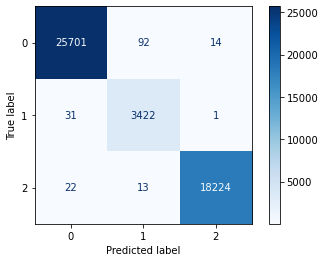

In [28]:
evaluate_model(pipe_model, X_train, y_train)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      6452
           1       0.35      0.44      0.39       863
           2       0.78      0.77      0.77      4565

    accuracy                           0.75     11880
   macro avg       0.65      0.67      0.65     11880
weighted avg       0.76      0.75      0.76     11880



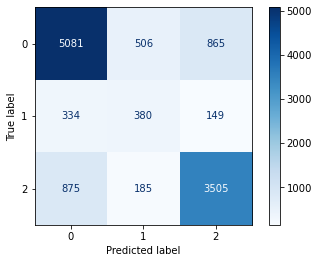

In [29]:
evaluate_model(pipe_model, X_test, y_test)

In [30]:
param_grid = {'dt__criterion' :['gini', 'entropy'],
    'dt__max_depth': [None, 5, 9]
}

grid = GridSearchCV(pipe_model, param_grid, scoring='f1_macro', verbose=2)
grid.fit(X_train, y_train)

basegrid.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .............dt__criterion=gini, dt__max_depth=None; total time=  34.9s
[CV] END .............dt__criterion=gini, dt__max_depth=None; total time=  35.8s
[CV] END .............dt__criterion=gini, dt__max_depth=None; total time=  34.1s
[CV] END .............dt__criterion=gini, dt__max_depth=None; total time=  33.5s
[CV] END .............dt__criterion=gini, dt__max_depth=None; total time=  32.8s
[CV] END ................dt__criterion=gini, dt__max_depth=5; total time=  23.0s
[CV] END ................dt__criterion=gini, dt__max_depth=5; total time=  23.7s
[CV] END ................dt__criterion=gini, dt__max_depth=5; total time=  23.4s
[CV] END ................dt__criterion=gini, dt__max_depth=5; total time=  23.5s
[CV] END ................dt__criterion=gini, dt__max_depth=5; total time=  23.3s
[CV] END ................dt__criterion=gini, dt__max_depth=9; total time=  28.5s
[CV] END ................dt__criterion=gini, dt__

NameError: name 'basegrid' is not defined

In [31]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_dt__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,34.041824,1.035570,0.180058,0.003267,gini,None,"{'dt__criterion': 'gini', 'dt__max_depth': None}",0.646972,0.648218,0.645227,0.652342,0.657427,0.650037,0.004377,1
1,23.227213,0.249873,0.178736,0.003829,gini,5,"{'dt__criterion': 'gini', 'dt__max_depth': 5}",0.477457,0.470445,0.478401,0.464503,0.473101,0.472782,0.005050,5
2,27.321712,0.505930,0.185262,0.006727,gini,9,"{'dt__criterion': 'gini', 'dt__max_depth': 9}",0.556896,0.554866,0.549135,0.544722,0.554462,0.552016,0.004459,3
3,28.779892,0.490389,0.180752,0.003208,entropy,None,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.638755,0.648861,0.649567,0.650777,0.652310,0.648054,0.004795,2
4,23.142414,0.236994,0.179432,0.004677,entropy,5,"{'dt__criterion': 'entropy', 'dt__max_depth': 5}",0.475528,0.441979,0.449994,0.469568,0.474952,0.462404,0.013800,6
5,25.375212,0.197578,0.176509,0.001661,entropy,9,"{'dt__criterion': 'entropy', 'dt__max_depth': 9}",0.552231,0.539025,0.556936,0.557184,0.538459,0.548767,0.008375,4


In [32]:
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('col',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('zero',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'district_code',
                                                   'population',
                                                   'construction_year',
                                                   'missing']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                               

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      6452
           1       0.36      0.44      0.40       863
           2       0.77      0.77      0.77      4565

    accuracy                           0.75     11880
   macro avg       0.65      0.66      0.65     11880
weighted avg       0.76      0.75      0.76     11880



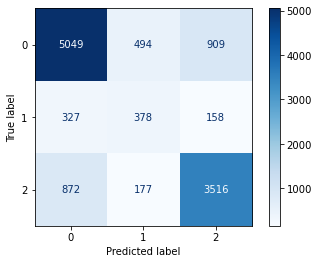

In [33]:
evaluate_model(best_model, X_test, y_test)

In [ ]:
0.8 *6452/11880+0.4*863/11880+0.77*4565/11880

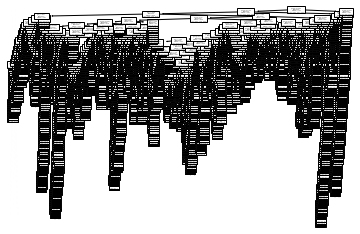

In [34]:
fig, axes = plt.subplots()
plot_tree(best_model['dt'])
plt.show()

In [35]:
cat_columns= [col for col in X.columns if X[col].dtype in ['object']]

cat_ohe_cols = best_model.named_steps['col'].named_transformers_['cat_pipe']['ohe'].get_feature_names(cat_columns).tolist()

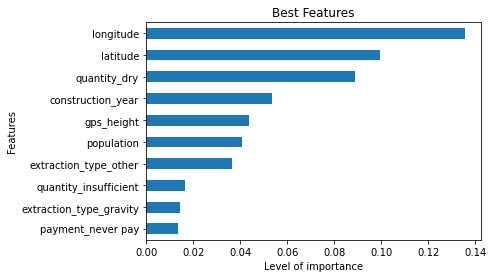

In [36]:
feat_cols = num_columns+ cat_ohe_cols 

X_train_tf = pd.DataFrame(best_model.named_steps['col'].fit_transform(X_train), columns=all_columns)


important_feats = pd.Series(best_model.named_steps['dt'].feature_importances_, 
                           index=feat_cols)

important_feats.sort_values(ascending=False)[:5]

top_feats = important_feats.sort_values(ascending=False).head(10)
plt.Figure(figsize=(5, 5))
top_feats.sort_values().plot(kind='barh')
plt.xlabel('Level of importance')
plt.ylabel('Features')
plt.title('Best Features');

# Feature Selection

## Variance Threshold filtering method 

In [37]:
threshold_ranges= np.linspace(0,1, num=6)

for thresh in threshold_ranges:
    selector = VarianceThreshold(thresh)
    reduce_featrue_train= selector.fit_transform(cleaned_df_train)
    reduce_featrue_test= selector.transform(cleaned_df_test)
    base2 = DecisionTreeClassifier()
    base2.fit(reduce_featrue_train, y_train)
    print(base2.score(reduce_featrue_train, y_train))
    print(base2.score(reduce_featrue_test, y_test))
    print("\n")
   

0.9971801346801347
0.7589225589225589


0.9913720538720538
0.7307239057239058


0.9859848484848485
0.6677609427609428


0.9859848484848485
0.6695286195286195


0.9859848484848485
0.6705387205387205


0.9836700336700337
0.5820707070707071




In [ ]:
reduce_featrue_train

> overfitting 

In [38]:
cleaned_df_train[cleaned_df_train.columns[selector.get_support(indices=True)]] 

,gps_height,longitude,population,missing
0,-0.966189,-0.082347,-0.388285,1.424385
1,1.990527,0.089031,-0.010377,-0.702057
2,-0.547718,0.634332,4.578495,-0.702057
3,-0.966189,-0.513692,-0.388285,1.424385
4,-0.966189,0.199466,-0.388285,1.424385
...,...,...,...,...
47515,-0.260560,0.638912,2.419026,-0.702057
47516,-0.966189,-0.023830,-0.388285,1.424385
47517,-0.101829,0.790675,-0.386125,-0.702057
47518,-0.351469,0.803744,0.302746,-0.702057


## Tree Pruning 

In [39]:
clf = DecisionTreeClassifier()

In [40]:
path = clf.cost_complexity_pruning_path(reduce_featrue_train, y_train)

In [41]:
ccp_alphas = path.ccp_alphas

In [42]:
ccp_alphas = ccp_alphas[:-1]

In [43]:
clfs= []

In [44]:
for ccp_alpha in ccp_alphas: 
    clf =DecisionTreeClassifier(random_state =0, ccp_alpha= ccp_alpha)
    clf.fit(reduce_featrue_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 5 with ccp_alpha: 0.0028112996843502325


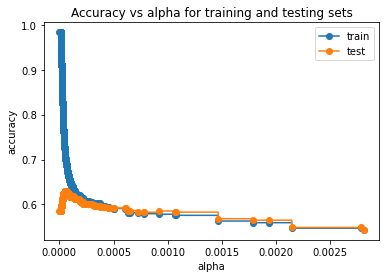

In [46]:
train_scores = [clf.score(reduce_featrue_train, y_train) for clf in clfs]
test_scores = [clf.score(reduce_featrue_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [103]:
ideal_ccp_alpha= alpha_results[(alpha_results['alpha']>0.0001)&((alpha_results['alpha']< 0.00012))]['alpha']

In [105]:
ideal_ccp_alpha

6639    0.000110
6640    0.000110
6641    0.000111
6642    0.000111
6643    0.000111
6644    0.000112
6645    0.000112
6646    0.000112
6647    0.000112
6648    0.000112
6649    0.000113
6650    0.000113
6651    0.000113
6652    0.000113
6653    0.000114
6654    0.000114
6655    0.000114
6656    0.000114
6657    0.000115
6658    0.000116
6659    0.000116
6660    0.000117
6661    0.000117
6662    0.000118
6663    0.000119
6664    0.000119
Name: alpha, dtype: float64

In [120]:
clf_pruned = DecisionTreeClassifier(random_state = 42, ccp_alpha= 0.000110)
clf_pruned = clf_pruned.fit(reduce_featrue_train, y_train)

[Text(197.23094835739744, 214.33371428571428, 'X[0] <= 0.984\ngini = 0.552\nsamples = 11880\nvalue = [6452, 863, 4565]'),
 Text(116.54947850944515, 208.12114285714284, 'X[1] <= 0.525\ngini = 0.562\nsamples = 9134\nvalue = [4679, 693, 3762]'),
 Text(44.62682729160388, 201.90857142857143, 'X[1] <= -0.62\ngini = 0.564\nsamples = 6873\nvalue = [3658, 593, 2622]'),
 Text(2.7660388729847822, 195.696, 'X[1] <= -0.676\ngini = 0.646\nsamples = 516\nvalue = [233, 137, 146]'),
 Text(1.816001205363869, 189.48342857142856, 'X[2] <= 0.314\ngini = 0.629\nsamples = 384\nvalue = [186, 84, 114]'),
 Text(1.546963989754407, 183.27085714285715, 'X[2] <= -0.037\ngini = 0.628\nsamples = 380\nvalue = [186, 84, 110]'),
 Text(1.277926774144945, 177.05828571428572, 'gini = 0.632\nsamples = 373\nvalue = [179, 84, 110]'),
 Text(1.816001205363869, 177.05828571428572, 'gini = 0.0\nsamples = 7\nvalue = [7, 0, 0]'),
 Text(2.0850384209733313, 183.27085714285715, 'gini = 0.0\nsamples = 4\nvalue = [0, 0, 4]'),
 Text(3.71

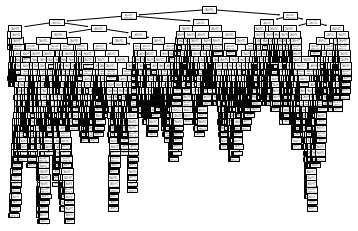

In [107]:
fig, axes = plt.subplots()
plot_tree(clf_pruned)


              precision    recall  f1-score   support

           0       0.64      0.77      0.70      6452
           1       0.54      0.05      0.09       863
           2       0.58      0.51      0.54      4565

    accuracy                           0.62     11880
   macro avg       0.58      0.44      0.44     11880
weighted avg       0.61      0.62      0.59     11880



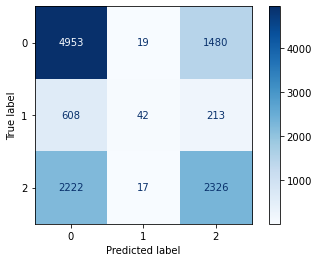

In [121]:
evaluate_model(clf_pruned,reduce_featrue_test, y_test)

              precision    recall  f1-score   support

           0       0.66      0.79      0.72     25807
           1       0.68      0.07      0.12      3454
           2       0.61      0.55      0.58     18259

    accuracy                           0.64     47520
   macro avg       0.65      0.47      0.47     47520
weighted avg       0.64      0.64      0.62     47520



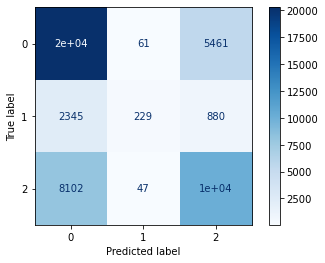

In [122]:
evaluate_model(clf_pruned,reduce_featrue_train, y_train)

> fix the overfitting issue but the scores are bad

## Final Model

In [116]:
gradient_pipe = imbpipeline(steps=[
    ('col', coltran),
    ('smote', SMOTE()),
    ('gb', GradientBoostingClassifier(learning_rate= 0.2, max_depth= 6, subsample= 0.7))
])


In [123]:
gradient_pipe.fit(X_train, y_train)

Pipeline(steps=[('col',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('zero',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'district_code',
                                                   'population',
                                                   'construction_year',
                                                   'missing']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                               

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      6452
           1       0.33      0.57      0.42       863
           2       0.84      0.73      0.78      4565

    accuracy                           0.76     11880
   macro avg       0.66      0.70      0.67     11880
weighted avg       0.78      0.76      0.77     11880



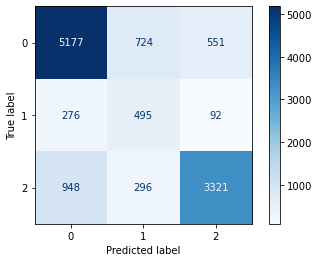

In [125]:
evaluate_model(gradient_pipe, X_test, y_test)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84     25807
           1       0.41      0.70      0.52      3454
           2       0.87      0.76      0.81     18259

    accuracy                           0.80     47520
   macro avg       0.71      0.77      0.72     47520
weighted avg       0.82      0.80      0.81     47520



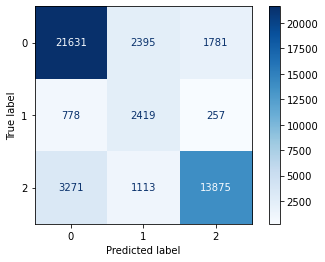

In [126]:
evaluate_model(gradient_pipe, X_train, y_train)